# The Tutorial to Run `maskrcnn-benchmark` on Server

Last Update: 

2019/01/02: the first version

In [1]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as mask_utils
from skimage import measure
from pycocotools.coco import COCO

## Installation

We mainly follow the step-by-step installation suggested in the [official document](https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/INSTALL.md). 

- **Step 1: Create a New ```conda``` Environment**. A seperate ```conda``` environment guarentees the independency which avoids unnecessary or even harmful changes to the root environment when installing the new packages. Enter ```conda create --name maskrcnn_benchmark``` to initialize the environment (env) and then activate it by ```source activate maskrcnn_benchmark```. Note that we should **activate the env everytime** before the formal implementation.

- **Step 2: Install the Required Packages**. 
    - ipython, yacs, matplotlib, ninja, jupyter notebook.
    - GCC >= 4.9 and <= 6.0. 
    - OpenCV for the webcam demo. 
    - PyTorch 1.0 and torchvision. [link](https://pytorch.org/get-started/locally/)
    - cocoapi (github). [link](https://github.com/cocodataset/cocoapi.git)
    - maskrcnn-benchmark (github). [link](https://github.com/facebookresearch/maskrcnn-benchmark)
    
We can test the deployment by running the ```demo.ipynb``` in ```./demo```.

## Perform Training on Own Datasets

This section mainly follows the instructions in this [post](https://blog.csdn.net/ChuiGeDaQiQiu/article/details/83868512). The main idea is to firstly convert our own datasets into coco data format, and then call the api directly to perform the training. **The difference between this approach and the [fine-tuning way](https://github.com/facebookresearch/maskrcnn-benchmark/issues/15) need to be further investigated.**

### Reformat the Custom Datasets
- **COCO Data Format**: [official description](http://cocodataset.org/#format-data). 
    - For image: it's critical to specify the right "file_name" (image directory).
    - For annotation: "area" and "bbox" can be computed via pycocotool.mask. "segmentation" can be encoded via the following sample codes given the binary image. Also note the value of "iscrowd". 
- **The COCO creator**: 
    - pycocotools (cocoapi). Especially the ```mask.py``` ([link](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py)).
    - pycococreator. [link](https://github.com/waspinator/pycococreator)
- **Related concepts**:
    - **RLE (Run-Length-Encoding)**: [Ref1](https://pws.yazd.ac.ir/latiff/teaching/DIP/13.pdf), [Ref2](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/mask.py). Note that the binary mask should be **transposed**, **flattened** and transfered into **uint8** format before encoding. The encoded RLE needs to be stored in a dictionary format `{'counts': rle (list), 'size': image size (list [h,w])}`.
    - **Polygon (Contour)**: [Ref1](https://github.com/facebookresearch/Detectron/issues/100), [Ref2](https://blog.csdn.net/silangquan/article/details/47054309#commentBox), [Ref3](https://en.wikipedia.org/wiki/Marching_squares). 
- **Check JSON Files**: the generated JSON file can be checked by `pycocotool.coco`.

In [2]:
def bimask_to_rle(binary_mask):
    rle=[]
    # flatten the bimask into vector
    flat_bimask = binary_mask.T.flatten().astype(np.uint8)
    # check the first element
    if flat_bimask[0]==1:
        rle.append(0)
    num=flat_bimask[0]
    counter=1
    # iteration
    for i in range(1,len(flat_bimask)): 
        if num==flat_bimask[i]:
            counter+=1
        else:
            num=flat_bimask[i]
            rle.append(counter)
            counter=1
    # update for the last counter
    rle.append(counter)
    return rle

# following codes from https://github.com/waspinator/pycococreator/blob/master/pycococreatortools/pycococreatortools.py
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour
def bimask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation
    Args:
        binary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation 
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)
    return polygons

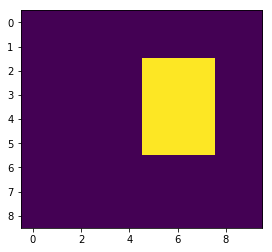

In [3]:
bimask=np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)
plt.imshow(bimask)

In [4]:
# uncompressed rle
rle_uncprs={'counts':bimask_to_rle(bimask),'size':list(bimask.shape)}
print(rle_uncprs)
# compressed rle
rle_cprs=mask_utils.frPyObjects(rle_uncprs,bimask.shape[0],bimask.shape[1])
rle_cprs['counts']=rle_cprs['counts'].decode("utf-8") # transfer bytes to utf-8 (json only supports utf-8)
print(rle_cprs)

{'counts': [47, 4, 5, 4, 5, 4, 21], 'size': [9, 10]}
{'size': [9, 10], 'counts': '_145000`0'}


In [5]:
# area
print('The area is:',mask_utils.area(rle_cprs))
# bbox
print('The bbox is:',mask_utils.toBbox(rle_cprs))

The area is: 12
The bbox is: [5. 2. 3. 4.]


In [6]:
# polygon
polygon=bimask_to_polygon(bimask)
print(polygon)

[[7.0, 5.5, 6.0, 5.5, 5.0, 5.5, 4.5, 5.0, 4.5, 4.0, 4.5, 3.0, 4.5, 2.0, 5.0, 1.5, 6.0, 1.5, 7.0, 1.5, 7.5, 2.0, 7.5, 3.0, 7.5, 4.0, 7.5, 5.0, 7.0, 5.5]]


check the generated data

In [7]:
annFile='./datasets/dsbw/validation.json'
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


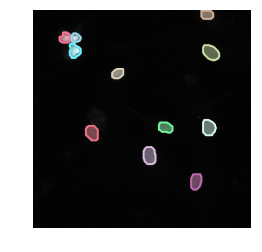

In [8]:
imgid=0
imgIds = coco.getImgIds(imgIds = [imgid])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('./datasets/dsbw/'+img['file_name'])
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=imgid,iscrowd=0)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

### Redirect the Path to Custom Datasets
- Modify the path of datasets in `maskrcnn_benchmark/config/paths_catalog.py`. 
    ```python
        ...
         DATASETS = {
        "coco_dsbw_train": { # must contain key words "coco".
            "img_dir":"dsbw/", # the root directory of image which will be concatenated with "file_name" in annotation file and construct the complete path.
            "ann_file":"dsbw/train.json" # directory of annotation files.
        },
        "coco_dsbw_val": {
            "img_dir":"dsbw/", 
            "ann_file":"dsbw/validation.json" 
        },
        "coco_dsbw_test": {
            "img_dir":"dsbw/", 
            "ann_file":"dsbw/test.json"
        },
        ...
    ```
- One alternative is to create a new `paths_catalog.py` file with the same implementations, and pass its directory as a config argument `PATHS_CATALOG` during training.
- **Note**: the dataset name in `paths_catalog.py` must include the keyword 'coco' to let the model process it by coco wrapper.

### Change Model Configuration File
The model configurations are stored in `./configs/*.yaml` and `./maskrcnn_benchmark/config/default.py`. The former one can be regarded as a specified setting for some common models. For the parameters that are not configured in `*.yaml`, the model will turn to `default.py`. In addition to above two ways, you can also amend the default settings when calling the `train_net.py` api. 

- `*.yaml`: We need to change the file name of datasets in `*.yaml`. The commented parts correspond to the default settings. 
    ```python
        ...
        DATASETS:
          TRAIN: ("coco_dsbw_train", "coco_dsbw_val") #("coco_2014_train", "coco_2014_valminusminival")
          TEST: ("coco_dsbw_test",) #("coco_2014_minival",)
        ...
    ```
- `default.py`: There are several parts that need to be modified.
    - Input: the extreme side of the image during training (including both `train_set` and `val_set`) and testing, as well as the pixel mean for all training images (**BGR order**).
    ```python
        # -----------------------------------------------------------------------------
        # INPUT
        # -----------------------------------------------------------------------------
        _C.INPUT = CN()
        # Size of the smallest side of the image during training
        _C.INPUT.MIN_SIZE_TRAIN = 256 #800  # (800,)
        # Maximum size of the side of the image during training
        _C.INPUT.MAX_SIZE_TRAIN = 1388 #1333
        # Size of the smallest side of the image during testing
        _C.INPUT.MIN_SIZE_TEST = 161 #800
        # Maximum size of the side of the image during testing
        _C.INPUT.MAX_SIZE_TEST = 696 #1333
        # Values to be used for image normalization
        _C.INPUT.PIXEL_MEAN = [43.53287505, 39.56061986, 48.22454996] #[102.9801, 115.9465, 122.7717]
        # Values to be used for image normalization
        _C.INPUT.PIXEL_STD = [1., 1., 1.]
        # Convert image to BGR format (for Caffe2 models), in range 0-255
        _C.INPUT.TO_BGR255 = True
    ```
    - Misc Options: specify the storage path of log files.
    ```python
        # ---------------------------------------------------------------------------- #
        # Misc options
        # ---------------------------------------------------------------------------- #
        _C.OUTPUT_DIR = "./dsbw_12_28/"

        _C.PATHS_CATALOG = os.path.join(os.path.dirname(__file__), "paths_catalog.py")
    ```

### Call `train_net.py` to Train the Model
- Back to the command line mode, and input `screen -S maskrcnn` to creat a new session.
- **Single GPU training**: for example, input `python tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.IMS_PER_BATCH 2 SOLVER.BASE_LR 0.0025 SOLVER.MAX_ITER 48000 SOLVER.STEPS "(32000, 42000)" TEST.IMS_PER_BATCH 1`. The formula of `train_net.py` is to specify the cofig file first and then modify the parameters if required.

In [21]:
python tools/train_net.py --config-file configs/e2e_mask_rcnn_R_50_FPN_1x.yaml SOLVER.IMS_PER_BATCH 2 SOLVER.BASE_LR 0.0025 SOLVER.MAX_ITER 48000 SOLVER.STEPS "(32000, 42000)" TEST.IMS_PER_BATCH 1

2018-12-28 20:22:43,700 maskrcnn_benchmark INFO: Using 1 GPUs
2018-12-28 20:22:43,700 maskrcnn_benchmark INFO: Namespace(config_file='configs/e2e_mask_rcnn_R_50_FPN_1x.yaml', distributed=False, local_rank=0, opts=['SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.0025', 'SOLVER.MAX_ITER', '48000', 'SOLVER.STEPS', '(32000, 42000)', 'TEST.IMS_PER_BATCH', '1'], skip_test=False)
2018-12-28 20:22:43,700 maskrcnn_benchmark INFO: Collecting env info (might take some time)
2018-12-28 20:22:47,397 maskrcnn_benchmark INFO: 
PyTorch version: 1.0.0
Is debug build: No
CUDA used to build PyTorch: 9.0.176

OS: CentOS Linux 7 (Core)
GCC version: (GCC) 5.2.0
CMake version: Could not collect

Python version: 3.7
Is CUDA available: Yes
CUDA runtime version: 9.0.176
GPU models and configuration: 
GPU 0: GeForce GT 710
GPU 1: Tesla K80
GPU 2: Tesla K80
GPU 3: Tesla K80
GPU 4: Tesla K80

Nvidia driver version: 390.87
cuDNN version: Probably one of the following:
/usr/local/cuda-8.0/cudnnv5.1.5_old/lib64/lib

2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer1.0.bn1.bias                   loaded from layer1.0.bn1.bias            of shape (64,)
2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer1.0.bn1.weight                 loaded from layer1.0.bn1.weight          of shape (64,)
2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer1.0.bn2.bias                   loaded from layer1.0.bn2.bias            of shape (64,)
2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer1.0.bn2.weight                 loaded from layer1.0.bn2.weight          of shape (64,)
2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer1.0.bn3.bias                   loaded from layer1.0.bn3.bias            of shape (256,)
2018-12-28 20:22:51,148 maskrcnn_benchmark.utils.model_serialization INFO: backbone.body.layer

2018-12-28 20:22:51,194 maskrcnn_benchmark.data.build WARNING: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
2018-12-28 20:22:52,462 maskrcnn_benchmark.trainer INFO: Start training
2018-12-28 20:23:01,752 maskrcnn_benchmark.trainer INFO: eta: 6:11:22  iter: 20  loss: 2.5330 (2.9782)  loss_classifier: 0.2363 (0.3135)  loss_box_reg: 0.0509 (0.0933)  loss_mask: 1.1156 (1.5102)  loss_o

2018-12-28 20:26:54,765 maskrcnn_benchmark.trainer INFO: eta: 6:57:21  iter: 460  loss: 1.2716 (1.4879)  loss_classifier: 0.1801 (0.2228)  loss_box_reg: 0.1450 (0.1729)  loss_mask: 0.2640 (0.3872)  loss_objectness: 0.3221 (0.3784)  loss_rpn_box_reg: 0.2732 (0.3266)  time: 0.5451 (0.5267)  data: 0.0194 (0.0295)  lr: 0.002363  max mem: 1942
2018-12-28 20:27:06,234 maskrcnn_benchmark.trainer INFO: eta: 6:58:43  iter: 480  loss: 1.1449 (1.4743)  loss_classifier: 0.1754 (0.2205)  loss_box_reg: 0.1360 (0.1716)  loss_mask: 0.2684 (0.3817)  loss_objectness: 0.3095 (0.3767)  loss_rpn_box_reg: 0.2392 (0.3238)  time: 0.5995 (0.5287)  data: 0.0198 (0.0296)  lr: 0.002430  max mem: 1942
2018-12-28 20:27:17,810 maskrcnn_benchmark.trainer INFO: eta: 7:00:07  iter: 500  loss: 1.0773 (1.4622)  loss_classifier: 0.1432 (0.2185)  loss_box_reg: 0.1313 (0.1707)  loss_mask: 0.2346 (0.3766)  loss_objectness: 0.3061 (0.3754)  loss_rpn_box_reg: 0.2372 (0.3210)  time: 0.5887 (0.5307)  data: 0.0209 (0.0295)  lr: 0

2018-12-28 20:31:36,932 maskrcnn_benchmark.trainer INFO: eta: 7:08:18  iter: 960  loss: 0.9952 (1.3017)  loss_classifier: 0.1492 (0.1897)  loss_box_reg: 0.1175 (0.1518)  loss_mask: 0.2072 (0.3178)  loss_objectness: 0.2908 (0.3480)  loss_rpn_box_reg: 0.2482 (0.2944)  time: 0.5997 (0.5463)  data: 0.0202 (0.0295)  lr: 0.002500  max mem: 1942
2018-12-28 20:31:48,256 maskrcnn_benchmark.trainer INFO: eta: 7:08:27  iter: 980  loss: 1.1079 (1.2972)  loss_classifier: 0.1150 (0.1885)  loss_box_reg: 0.1184 (0.1512)  loss_mask: 0.2393 (0.3161)  loss_objectness: 0.2931 (0.3474)  loss_rpn_box_reg: 0.2564 (0.2941)  time: 0.5812 (0.5467)  data: 0.0227 (0.0295)  lr: 0.002500  max mem: 1942
2018-12-28 20:31:59,967 maskrcnn_benchmark.trainer INFO: eta: 7:08:52  iter: 1000  loss: 1.1372 (1.2946)  loss_classifier: 0.1636 (0.1881)  loss_box_reg: 0.1119 (0.1506)  loss_mask: 0.2447 (0.3148)  loss_objectness: 0.2823 (0.3466)  loss_rpn_box_reg: 0.2912 (0.2943)  time: 0.5993 (0.5475)  data: 0.0239 (0.0296)  lr: 

2018-12-28 20:36:08,306 maskrcnn_benchmark.trainer INFO: eta: 7:08:52  iter: 1440  loss: 1.0189 (1.2186)  loss_classifier: 0.1204 (0.1762)  loss_box_reg: 0.1147 (0.1412)  loss_mask: 0.2414 (0.2902)  loss_objectness: 0.2745 (0.3294)  loss_rpn_box_reg: 0.2217 (0.2816)  time: 0.5265 (0.5527)  data: 0.0142 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:36:18,774 maskrcnn_benchmark.trainer INFO: eta: 7:08:22  iter: 1460  loss: 0.8738 (1.2144)  loss_classifier: 0.0869 (0.1751)  loss_box_reg: 0.0712 (0.1404)  loss_mask: 0.2166 (0.2891)  loss_objectness: 0.2415 (0.3285)  loss_rpn_box_reg: 0.2705 (0.2814)  time: 0.5076 (0.5523)  data: 0.0150 (0.0290)  lr: 0.002500  max mem: 1942
2018-12-28 20:36:30,289 maskrcnn_benchmark.trainer INFO: eta: 7:08:26  iter: 1480  loss: 0.9277 (1.2116)  loss_classifier: 0.1161 (0.1747)  loss_box_reg: 0.1059 (0.1401)  loss_mask: 0.2150 (0.2883)  loss_objectness: 0.2648 (0.3280)  loss_rpn_box_reg: 0.2234 (0.2807)  time: 0.5570 (0.5526)  data: 0.0222 (0.0290)  lr

2018-12-28 20:40:40,105 maskrcnn_benchmark.trainer INFO: eta: 7:07:03  iter: 1920  loss: 0.9628 (1.1614)  loss_classifier: 0.1241 (0.1654)  loss_box_reg: 0.1038 (0.1334)  loss_mask: 0.2100 (0.2745)  loss_objectness: 0.2824 (0.3154)  loss_rpn_box_reg: 0.2255 (0.2727)  time: 0.6107 (0.5561)  data: 0.0212 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:40:51,726 maskrcnn_benchmark.trainer INFO: eta: 7:07:04  iter: 1940  loss: 0.8779 (1.1590)  loss_classifier: 0.1145 (0.1652)  loss_box_reg: 0.1124 (0.1332)  loss_mask: 0.2222 (0.2740)  loss_objectness: 0.2370 (0.3146)  loss_rpn_box_reg: 0.2047 (0.2720)  time: 0.5966 (0.5563)  data: 0.0291 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:41:03,260 maskrcnn_benchmark.trainer INFO: eta: 7:07:02  iter: 1960  loss: 0.8042 (1.1560)  loss_classifier: 0.0833 (0.1646)  loss_box_reg: 0.0593 (0.1328)  loss_mask: 0.1729 (0.2731)  loss_objectness: 0.2425 (0.3142)  loss_rpn_box_reg: 0.1743 (0.2714)  time: 0.5846 (0.5565)  data: 0.0179 (0.0291)  lr

2018-12-28 20:45:14,393 maskrcnn_benchmark.trainer INFO: eta: 7:04:56  iter: 2400  loss: 0.9331 (1.1181)  loss_classifier: 0.1233 (0.1578)  loss_box_reg: 0.1116 (0.1280)  loss_mask: 0.2164 (0.2630)  loss_objectness: 0.2615 (0.3041)  loss_rpn_box_reg: 0.2448 (0.2653)  time: 0.5687 (0.5591)  data: 0.0206 (0.0289)  lr: 0.002500  max mem: 1942
2018-12-28 20:45:26,417 maskrcnn_benchmark.trainer INFO: eta: 7:05:01  iter: 2420  loss: 1.0911 (1.1178)  loss_classifier: 0.1344 (0.1579)  loss_box_reg: 0.1133 (0.1279)  loss_mask: 0.2480 (0.2629)  loss_objectness: 0.2350 (0.3038)  loss_rpn_box_reg: 0.2752 (0.2654)  time: 0.6187 (0.5595)  data: 0.0233 (0.0290)  lr: 0.002500  max mem: 1942
2018-12-28 20:45:38,133 maskrcnn_benchmark.trainer INFO: eta: 7:04:59  iter: 2440  loss: 0.9536 (1.1165)  loss_classifier: 0.1337 (0.1577)  loss_box_reg: 0.0927 (0.1277)  loss_mask: 0.1904 (0.2625)  loss_objectness: 0.2431 (0.3034)  loss_rpn_box_reg: 0.2129 (0.2653)  time: 0.6139 (0.5597)  data: 0.0245 (0.0290)  lr

2018-12-28 20:49:49,873 maskrcnn_benchmark.trainer INFO: eta: 7:02:19  iter: 2880  loss: 0.9157 (1.0821)  loss_classifier: 0.0984 (0.1519)  loss_box_reg: 0.0941 (0.1237)  loss_mask: 0.2181 (0.2548)  loss_objectness: 0.2262 (0.2941)  loss_rpn_box_reg: 0.2500 (0.2576)  time: 0.5438 (0.5616)  data: 0.0196 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:50:01,526 maskrcnn_benchmark.trainer INFO: eta: 7:02:14  iter: 2900  loss: 0.9179 (1.0812)  loss_classifier: 0.1157 (0.1517)  loss_box_reg: 0.0920 (0.1236)  loss_mask: 0.1988 (0.2545)  loss_objectness: 0.2399 (0.2939)  loss_rpn_box_reg: 0.2343 (0.2575)  time: 0.6111 (0.5617)  data: 0.0191 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:50:13,223 maskrcnn_benchmark.trainer INFO: eta: 7:02:10  iter: 2920  loss: 0.8938 (1.0801)  loss_classifier: 0.1079 (0.1515)  loss_box_reg: 0.0824 (0.1234)  loss_mask: 0.2134 (0.2543)  loss_objectness: 0.2268 (0.2936)  loss_rpn_box_reg: 0.1922 (0.2572)  time: 0.6056 (0.5619)  data: 0.0206 (0.0291)  lr

2018-12-28 20:54:26,886 maskrcnn_benchmark.trainer INFO: eta: 6:59:28  iter: 3360  loss: 0.8276 (1.0556)  loss_classifier: 0.0865 (0.1475)  loss_box_reg: 0.0774 (0.1204)  loss_mask: 0.1891 (0.2483)  loss_objectness: 0.2195 (0.2869)  loss_rpn_box_reg: 0.1870 (0.2526)  time: 0.5797 (0.5638)  data: 0.0191 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:54:37,613 maskrcnn_benchmark.trainer INFO: eta: 6:59:10  iter: 3380  loss: 0.7580 (1.0540)  loss_classifier: 0.0919 (0.1472)  loss_box_reg: 0.0934 (0.1202)  loss_mask: 0.1945 (0.2480)  loss_objectness: 0.1907 (0.2864)  loss_rpn_box_reg: 0.1639 (0.2521)  time: 0.5377 (0.5637)  data: 0.0192 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:54:49,844 maskrcnn_benchmark.trainer INFO: eta: 6:59:11  iter: 3400  loss: 0.8983 (1.0534)  loss_classifier: 0.1279 (0.1471)  loss_box_reg: 0.0915 (0.1202)  loss_mask: 0.2151 (0.2479)  loss_objectness: 0.2320 (0.2863)  loss_rpn_box_reg: 0.1755 (0.2519)  time: 0.6273 (0.5639)  data: 0.0223 (0.0291)  lr

2018-12-28 20:59:04,047 maskrcnn_benchmark.trainer INFO: eta: 6:56:13  iter: 3840  loss: 0.8850 (1.0323)  loss_classifier: 0.1033 (0.1434)  loss_box_reg: 0.1011 (0.1175)  loss_mask: 0.2069 (0.2433)  loss_objectness: 0.2160 (0.2804)  loss_rpn_box_reg: 0.2394 (0.2478)  time: 0.5882 (0.5655)  data: 0.0172 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:59:15,469 maskrcnn_benchmark.trainer INFO: eta: 6:56:03  iter: 3860  loss: 0.8933 (1.0317)  loss_classifier: 0.1180 (0.1433)  loss_box_reg: 0.0888 (0.1175)  loss_mask: 0.2209 (0.2432)  loss_objectness: 0.2045 (0.2801)  loss_rpn_box_reg: 0.2125 (0.2477)  time: 0.5664 (0.5655)  data: 0.0187 (0.0291)  lr: 0.002500  max mem: 1942
2018-12-28 20:59:27,195 maskrcnn_benchmark.trainer INFO: eta: 6:55:56  iter: 3880  loss: 0.9887 (1.0314)  loss_classifier: 0.1316 (0.1432)  loss_box_reg: 0.1050 (0.1175)  loss_mask: 0.1976 (0.2431)  loss_objectness: 0.2142 (0.2798)  loss_rpn_box_reg: 0.2704 (0.2478)  time: 0.5997 (0.5657)  data: 0.0202 (0.0291)  lr

2018-12-28 21:03:39,357 maskrcnn_benchmark.trainer INFO: eta: 6:52:20  iter: 4320  loss: 0.9165 (1.0127)  loss_classifier: 0.1166 (0.1400)  loss_box_reg: 0.1083 (0.1151)  loss_mask: 0.2224 (0.2392)  loss_objectness: 0.2073 (0.2745)  loss_rpn_box_reg: 0.1864 (0.2439)  time: 0.6170 (0.5664)  data: 0.0255 (0.0294)  lr: 0.002500  max mem: 1942
2018-12-28 21:03:50,700 maskrcnn_benchmark.trainer INFO: eta: 6:52:09  iter: 4340  loss: 0.8441 (1.0122)  loss_classifier: 0.1067 (0.1400)  loss_box_reg: 0.1004 (0.1150)  loss_mask: 0.2028 (0.2391)  loss_objectness: 0.2247 (0.2744)  loss_rpn_box_reg: 0.1704 (0.2437)  time: 0.5873 (0.5664)  data: 0.0165 (0.0294)  lr: 0.002500  max mem: 1942
2018-12-28 21:04:01,458 maskrcnn_benchmark.trainer INFO: eta: 6:51:52  iter: 4360  loss: 0.7698 (1.0111)  loss_classifier: 0.0686 (0.1398)  loss_box_reg: 0.0692 (0.1149)  loss_mask: 0.1616 (0.2388)  loss_objectness: 0.2190 (0.2742)  loss_rpn_box_reg: 0.1895 (0.2434)  time: 0.5405 (0.5663)  data: 0.0176 (0.0294)  lr